In [22]:

import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets
import numpy as np
import scipy as sp
import pymc3 as pm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics


In [13]:


caddy = pd.read_csv('caddy_jz.csv')
caddy = caddy.rename(columns={'ObjectPrice': 'target'})
caddy.replace([np.inf, -np.inf], np.nan, inplace = True)    # removing -inf and inf values
caddy.dropna(axis='rows', inplace = True)
target = caddy["target"]
caddy.drop(columns=['target'], inplace = True)
X_train, X_test, y_train, y_test = train_test_split(caddy, target, test_size=.3)



Antall forklaringsvariabler vi har endt opp med :  5
['YearModel-Milageroot' 'YearModel+EngineVolumeexp' 'Milage+YearModelsq'
 'Milage*RegistrationClass_Varebilsq' 'Weight/Effectlog']


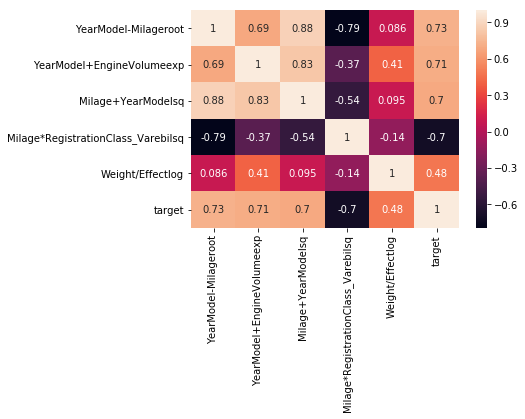

In [14]:

# Lager nye transformarsjoner av variablene og interaksjoner

def lag_nye_var(X_train, X_test, y_train, n_break_points = 10, max_collinearity = 0.7, min_linearity_with_y = 0.35,\
                max_forklaringsvariabler = 40, give_X_names = None, plot = None):

    columns = list(X_train.columns)
    # TRASNSFORMING
    for j in range(len(X_train.T)):

        #FOR TRAIN
        X_train[X_train.iloc[:,j].name+"sq"] = X_train.iloc[:,j].transform(lambda x: x**(2))
        X_train[X_train.iloc[:,j].name+"qb"] = X_train.iloc[:,j].transform(lambda x: x**(3))
        X_train[X_train.iloc[:,j].name+"root"] = X_train.iloc[:,j].transform(lambda x: x**(1/2))
        X_train[X_train.iloc[:,j].name+"log"] = X_train.iloc[:,j].transform(lambda x: np.log(x))
        X_train[X_train.iloc[:,j].name+"exp"] = X_train.iloc[:,j].transform(lambda x: np.exp(x))

        #FOR TEST
        X_test[X_test.iloc[:,j].name+"sq"] = X_test.iloc[:,j].transform(lambda x: x**(2))
        X_test[X_test.iloc[:,j].name+"qb"] = X_test.iloc[:,j].transform(lambda x: x**(3))
        X_test[X_test.iloc[:,j].name+"root"] = X_test.iloc[:,j].transform(lambda x: x**(1/2))
        X_test[X_test.iloc[:,j].name+"log"] = X_test.iloc[:,j].transform(lambda x: np.log(x))
        X_test[X_test.iloc[:,j].name+"exp"] = X_test.iloc[:,j].transform(lambda x: np.exp(x))

    # INTERACTION
    columns2 = list(X_train.columns)
    for j in range(len(columns)):
        for i in range(len(columns2)):
            if columns[j] != X_train.iloc[:,i].name:

                #FOR TRAIN
                X_train[columns[j]+"+"+columns2[i]] = X_train[columns[j]] + X_train[columns2[i]]
                X_train[columns[j]+"-"+columns2[i]] = X_train[columns[j]] - X_train[columns2[i]]
                X_train[columns[j]+"*"+columns2[i]] = X_train[columns[j]] * X_train[columns2[i]]
                X_train[columns[j]+"/"+columns2[i]] = X_train[columns[j]] / X_train[columns2[i]]

                #FOR TEST
                X_test[columns[j]+"+"+columns2[i]] = X_test[columns[j]] + X_test[columns2[i]]
                X_test[columns[j]+"-"+columns2[i]] = X_test[columns[j]] - X_test[columns2[i]]
                X_test[columns[j]+"*"+columns2[i]] = X_test[columns[j]] * X_test[columns2[i]]
                X_test[columns[j]+"/"+columns2[i]] = X_test[columns[j]] / X_test[columns2[i]]

#         print(j/len(columns))

    X_train['target'] = y_train
    X_train.replace([np.inf, -np.inf], np.nan, inplace = True)
    X_train.dropna(axis='columns', inplace = True)
    X_test.replace([np.inf, -np.inf], np.nan, inplace = True)
    X_test.dropna(axis='columns', inplace = True)

    # FOR MORO SPLITTER VI y I n INTERVALLER, OG SJEKKER FOR LINEAERITET I HVERT INTERVALL
    antall_intervaller = n_break_points
    lengde = np.sqrt( (np.max(y_train) - np.min(y_train))**2 )/ antall_intervaller
    all_indexes = []

    for k in range(antall_intervaller):

        interval_split = np.where(np.logical_and(y_train>=np.min(y_train)+(lengde*k), \
                                                 y_train<np.min(y_train)+(lengde*(k+1))))[0]
        mid_X_train = np.array(X_train)[interval_split]
        mid_X_train = pd.DataFrame(mid_X_train)

        all_diff_correlations = np.absolute(np.array(mid_X_train.corr()))


        train_linear_corr = all_diff_correlations[:-1,-1]   # KORRELASJONSRADEN TIL y
        train_linear_corr = np.nan_to_num(train_linear_corr)
        index_of_best_linear_relation = train_linear_corr.argsort()[::-1]

        if train_linear_corr[index_of_best_linear_relation][0] > 0:
            index_of_good_fit = [index_of_best_linear_relation[0]]
            count = 1
            while len(index_of_good_fit) < int(max_forklaringsvariabler/antall_intervaller) and count != len(index_of_best_linear_relation)\
             and train_linear_corr[index_of_best_linear_relation[count]] > min_linearity_with_y:
                wrong = 0
                for k in range(len(index_of_good_fit)):
                    if wrong == 0:
                        value = np.absolute(all_diff_correlations[index_of_good_fit[k],index_of_best_linear_relation[count]])
                        if value > max_collinearity:
                            wrong = 1
                            break
                if wrong == 0:
                    index_of_good_fit.append(index_of_best_linear_relation[count])
                count += 1
            all_indexes.append(index_of_good_fit)


    print("Antall forklaringsvariabler vi har endt opp med : ", len(np.unique(np.concatenate(all_indexes))))
    column_names_of_best_fit = np.array(X_train.columns)[np.unique(np.concatenate(all_indexes))]

    X_train = X_train[column_names_of_best_fit]
    X_test = X_test[column_names_of_best_fit]

    # Printer forklaringsvariablene
    if give_X_names != None:
        print(column_names_of_best_fit)
    # Plotter om man vil
    if plot != None:
        X_train['target'] = y_train
        sns.heatmap(X_train.corr(), annot=True)
        plt.show()
        # PAIRPLOT SER FORFERDELIG UT I JUPYTER
#         sns.pairplot(X_train)
#         plt.show()
        X_train.drop(columns=['target'], inplace = True)

    return(X_train, X_test, y_train)





X_train, X_test, y_train = lag_nye_var(X_train, X_test, y_train, n_break_points = 6, \
    max_collinearity = 0.75, min_linearity_with_y = 0.5, max_forklaringsvariabler = 8, give_X_names = 1, plot = 1)





In [16]:

# SKALERER DATAEN

x1 = X_train.values #returns a numpy array
x2 = X_test.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled1 = min_max_scaler.fit_transform(x1)
x_scaled2 = min_max_scaler.fit_transform(x2)
X_train = pd.DataFrame(x_scaled1)
X_test = pd.DataFrame(x_scaled2)

y_train = y_train / 10000
y_test = y_test / 10000



In [17]:


# PYMC3 VERSJON MED LITT FORSKJELLIGE SD, NU, a, b, LIGGENDE IGJEN SOM EKSEMPEL


linear_model = pm.Model()

with linear_model: 
    # Priors

    # sigma = pm.HalfNormal('sigma', sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=5)
    # sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    # sigma2 = pm.Uniform('sigma2', lower=0, upper=2)
    sigma2 = pm.Uniform('sigma2', lower=0, upper=30)
    # sigma2 = pm.HalfNormal('sigma2', sd=50)
    sigma3 = pm.Uniform('sigma3', lower=0, upper=10)
    # sigma3 = pm.HalfCauchy('sigma3', sd=10) # HalfCauchy har lenger/feitere hale


    nu = pm.Uniform('nu', lower=20, upper=90)
    # nu = pm.HalfNormal('nu', sd=1)
    nu2 = pm.Uniform('nu2', lower=20, upper=90)
    # nu2 = pm.HalfNormal('nu2', sd=5)
    nu3 = pm.Uniform('nu3', lower=20, upper=90)


    # Alpha her er interception, og Beta er Betaverdiene.
    alpha = pm.StudentT("alpha", mu=y_train.mean(),sd=sigma, nu = nu)
    # alpha = pm.Normal("alpha", mu=y_train.mean(),sd=sigma)
    # alpha = pm.Gamma('alpha', sd=sigma, mu=y_train.mean())
    betas = pm.StudentT("betas", mu=0,sd=sigma2, nu = nu2, shape=np.shape(X_train)[1])
    # betas = pm.Normal("betas", mu=0,sd=sigma2, shape=np.shape(X_train)[1])
    # alpha = pm.Gamma('lambda', alpha=sigma, beta=y_train.mean())


    # betas = pm.Normal("betas", mu=0,sd=sigma2, shape=np.shape(X_train)[1])
    # betas = pm.Uniform('betas', -3, 3, shape=np.shape(X_train)[1])

    # Her er altsA den lineaere modellen satt sammen 
    mu = alpha + pm.math.dot(betas, X_train.T)

    # Og sA sier jeg at modellen igjen er StudenT distrubuert, eller noe annet om du vil.
    # likelihood = pm.Normal("likelihood", mu=mu, sd=sigma, observed=y_train)
    likelihood = pm.StudentT("likelihood", mu=mu, sd=sigma3, nu = nu3, observed=y_train)
    # likelihood = pm.Gamma("likelihood", mu=mu, sd=sigma3, observed=y_train)
    # likelihood = pm.Normal("likelihood", mu=mu, sd=sigma3, observed=y_train)
    # likelihood = pm.NormalMixture('likelihood', nu3, mu, tau=sigma3, observed=y_train)


    # pA min PC funker det ikke, men skal kunne brukes GPU og flere cores
    # trace = pm.fit(1000, step, cores = 2)
    trace = pm.fit(method=pm.ADVI(), n=100000)




Average Loss = 1,156.6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:09<00:00, 769.54it/s]
Finished [100%]: Average Loss = 1,156.5


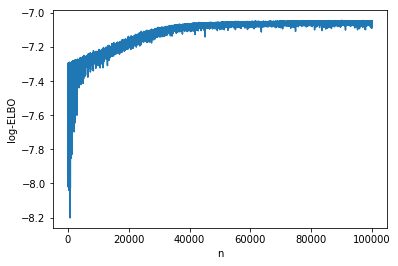

In [18]:



# ELBO
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(trace.hist),
     'n': np.arange(trace.hist.shape[0])})

_ = sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)
plt.show()



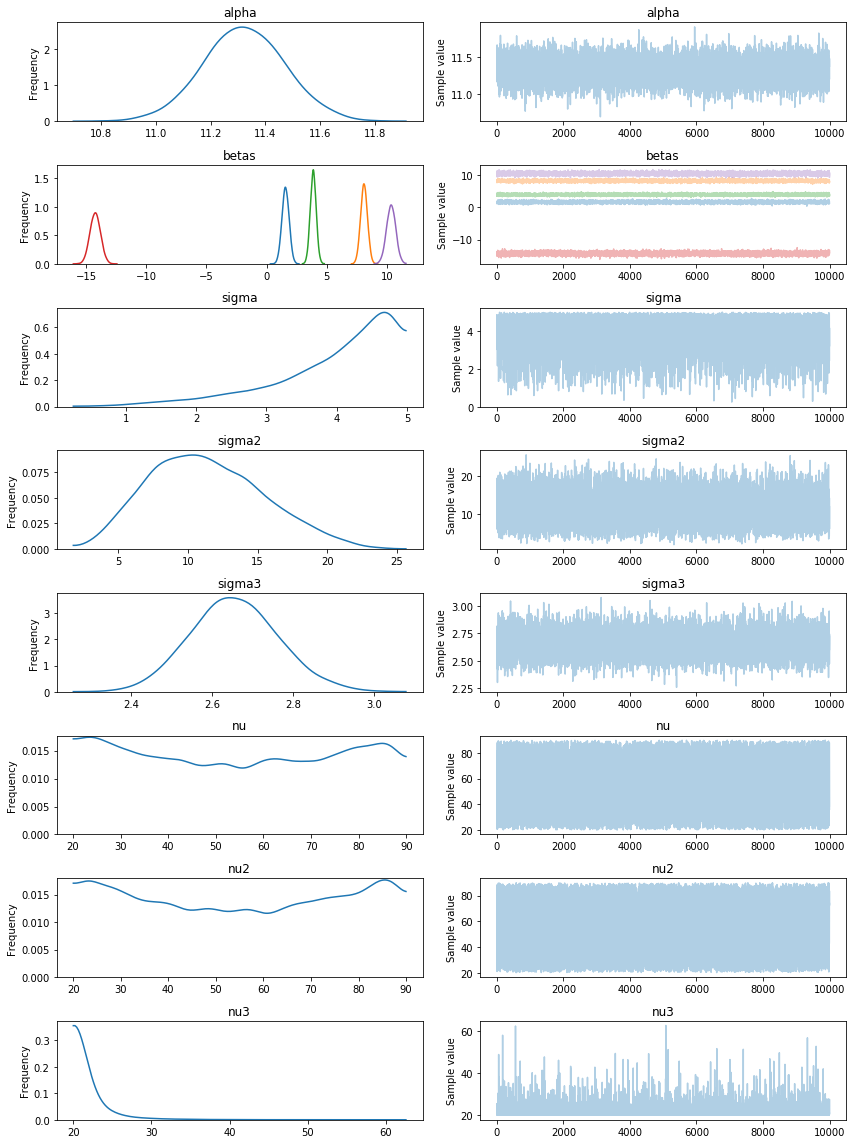

               mean         sd  mc_error    hpd_2.5   hpd_97.5
alpha     11.322052   0.147131  0.001538  11.040266  11.619171
betas__0   1.578543   0.287004  0.002513   1.020360   2.141754
betas__1   8.109782   0.277160  0.002972   7.591368   8.675304
betas__2   3.883817   0.240232  0.002271   3.415375   4.356182
betas__3 -14.248058   0.424872  0.005047 -15.042832 -13.378719
betas__4  10.360734   0.375424  0.003064   9.590991  11.073016
sigma      3.953604   0.863092  0.007960   2.139403   4.981571
sigma2    11.322737   4.072320  0.040174   4.187163  19.486963
sigma3     2.655416   0.107647  0.001195   2.455133   2.879486
nu        54.675272  21.004394  0.228248  20.724295  86.799757
nu2       55.116294  21.269491  0.200656  21.795729  88.079387
nu3       21.880864   2.930477  0.027791  20.005219  26.712833


In [19]:

# OPPSUMMERING

advi_trace = trace.sample(10000)
pm.traceplot(advi_trace)
plt.show()
print(pm.summary(advi_trace))



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 899.18it/s]


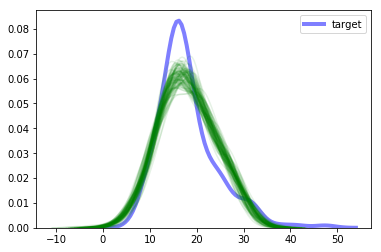

In [20]:

# ET PAR A NU VERDIENE SER UBRUKELIGE UT. MULIG DET ER FEIL DISTRUBUSJON SOM ER BRUKT


ppc = pm.sample_posterior_predictive(advi_trace, samples=5000, model=linear_model)

# sns.kdeplot(y_train, alpha=0.5, lw=4, color='b') # HER ER DET BRUKT TRAIN I EKSEMPLENE JEG HAR SETT, MEN BRUKER TEST LIKEVEL
sns.kdeplot(y_test, alpha=0.5, lw=4, color='b')
for i in range(100):
    sns.kdeplot(ppc['likelihood'][i], alpha=0.1, color='g')

plt.show()



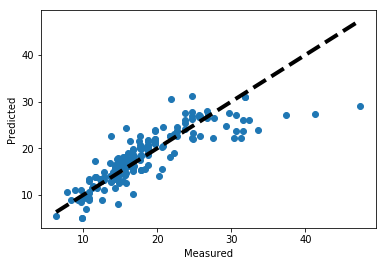

In [21]:


chain = advi_trace[2000:]
alpha_pred = chain['alpha'].mean()
betas_pred = chain['betas'].mean(axis=0)
y_pred = alpha_pred + np.dot(betas_pred, X_test.T)


# Plotter for A sjekke, y_pred vs y_test, som burde gi en god indikasjon pA hvordan vi har gjort det
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()



In [23]:

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(np.min(y_test), np.max(y_test), np.mean(y_test))

result = ((y_pred - y_test) / y_test*100).round()
print('Mean Absolute Error: %.1f percent.' % abs(result).mean())


Mean Absolute Error: 2.3513213807186224
Mean Squared Error: 11.585327820549464
Root Mean Squared Error: 3.40372264154256
6.377 47.3955 18.089153846153845
Mean Absolute Error: 12.8 percent.
